# Module 0, Notebook 2: Simple classification of Brain images into MRI vs PET

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/julclu/CSC509/blob/main/Module0/Module0_NB2_v0.ipynb)


In this Jupyter notebook, you will learn to build a basic classification model using convolutional neural networks to classify  medical images generated from two different modalities namely PET and MRI. We will be using the Keras API for the classification.

In order to enable ease of access we have converted all the DICOM formatted images into JPEG format and randomly sorted them into training and test set. 

## Some basics on classification problems
1. Classification problems can be set-up as a binary (eg. cat vs dogs) or multi-class (eg. cat, dog, chicken and turtle) classification. 
2. In the current scenario we are doing a **Binary** classification as to whether an image is a MRI image or PET image. 
3. In classification problems you should pay attention to the performance metrics such as Accuracy, area under receiver operating curve (AUROC) and area under precision recall curve (AUPRC). These metrics help us determine if our model is doing what we intended it for. 
4. The above metrics are calculated based on if the labels are True positive/negative (TP/N) and False positive/negative (FP/N). Your actual data only has True positives and negatives. False predictions are done by the model. 
5. Depending on the context of the problem we might pick which performance metric to pay attention to. For instance, if we are predicting if a person has cancer or not based on health record, it is very important that we don't miss someone with cancer (True Negative) than predicting a healthy person as cancerous (False Positive). 
Let's define it more in numbers: Let's say we would like to predict if a person has cancer or not based on health record. And you are given 1000 data points to train with. Assume only 30 people in the data do actually have cancer. i.e. 30 TP and 970 TN, if we predict one of the 970 as having cancer it is considered False Positive (FP). We are more interested in finding people who have cancer over misclassifications and therefore we care more about the accuracy of predicting the one class over the other. 
6. Most classification problems are set up similar to the example above. Notice we have data more on the non-cancerous people than cancerous one. This is called a class imbalance. When we have such a class imbalance it is important to pay attention to how we define the problem. 

## Let's continue with the notebook we will lean more on the way. 

In [1]:
#Load packages
import numpy as np
import pandas as pd
import os
import math
import PIL
from pathlib import Path
import glob as gb
from collections import Counter

from tqdm import tqdm
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import matplotlib.image as img

from google.colab import drive

Lets mount the drive 
we have already created a link to the data via shortcuts. The folder are arranged as such: 


> /content/drive/MyDrive/Module0/CNN

>> /content/drive/MyDrive/Module0/CNN/TRAIN

>>>/content/drive/MyDrive/Module0/CNN/TRAIN/MRI
>>>/content/drive/MyDrive/Module0/CNN/TRAIN/PET
    
>>/content/drive/MyDrive/Module0/CNN/TEST

>>>>/content/drive/MyDrive/Module0/CNN/TEST/MRI
>>>>/content/drive/MyDrive/Module0/CNN/TEST/PET



In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train= '/content/drive/MyDrive/Module0/CNN/TRAIN/'
test = '/content/drive/MyDrive/Module0/CNN/TEST/'

Lets check how many images there are under each label in training and validation sets

In [4]:
num_MRI_train_pts = len(gb.glob(train+'MRI/*.jpg'))
num_MRI_test_pts = len(gb.glob(test+'MRI/*.jpg'))
print('There are {} MRI images in the training folder'.format(num_MRI_train_pts)+'\n'+
      'and {} in the test folder'.format(num_MRI_test_pts))


num_PET_train_pts = len(gb.glob(train+'PET/*.jpg'))
num_PET_test_pts = len(gb.glob(test+'PET/*.jpg'))
print('There are {} PET images in the training folder'.format(num_PET_train_pts)+'\n'+
      'and {} images in the test folder'.format(num_PET_test_pts))

There are 0 MRI images in the training folder
and 0 in the test folder
There are 0 PET images in the training folder
and 0 images in the test folder


As you can see there is a large class imbalance, we have more MRI images than we have PET images. These images are in gray scale and have different patient data, let take a look at few of training images.

IndexError: ignored

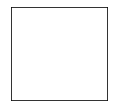

In [5]:
mri_train = gb.glob(train+'MRI/*.jpg')
pet_train = gb.glob(train+'PET/*.jpg')

mri_test = gb.glob(test+'MRI/*.jpg')
pet_test = gb.glob(test+'PET/*.jpg')


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #MRI images 
    plt.imshow(img.imread(mri_train[i]))
    plt.xlabel(i)
plt.show()

Lets look at the test set

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #MRI images 
    plt.imshow(img.imread(mri_test[i]))
    plt.xlabel(i)
plt.show()

Lets look at the PET image training set likewike

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #PET images 
    plt.imshow(img.imread(pet_train[i]))
    plt.xlabel(i)
plt.show()

As you can see the images in the MRI data set are inclusive of cronal, axial and sagital slices. There are a few composite images and FLAIR images. Look at the PET data set they are uniformly axial slices. As we learned earlier in the lectures there are fundemental differences between what is getting imaged and how it is captured. We want the CNN to learn this.

**Look at the PET test data on your own in the below code block**

Next, let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code.

Note the image size parameter it is set to 100 X 100 means we are asking Keras to read all the images as an 100 pixel by 100 pixel resolution. This is also the dimensions of the first layer in your CNN, so if you would like for the training to run faster or slower you can tweak this parameter. But I reccomend not changing this. 

We will be splitting images in the train folder into 80% train and 20% validation set.

In [ ]:
 train_ds = tf.keras.utils.image_dataset_from_directory(
  train,
  validation_split=0.2,
  subset="training",
  seed=123, image_size=(100, 100),
  batch_size=32)

Similarly lets create test and validation set. This is the 20% subset of the training data. Once you finish going through this notebook. **As a homework play around with a 60/40 50/50 spilt. Notice the seed parameter it is included to improve the reproducablity of the training and validation split. If you dont specify it the code will pick a random number and everytime you run this it will give you a different result.**

In [ ]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  train,
  validation_split=0.2,
  subset="validation",
  seed=123, image_size=(100, 100),
  batch_size=32)

In [ ]:
# Test set will not be shown to the model 
#it will be used to calculate performance on the trained model
test_ds = tf.keras.utils.image_dataset_from_directory(test,image_size=(100, 100))

These 371 images will be our independent test set which will show how our model performs on data that it hasn't seen before. 

Lets check the class names in the dataset, Keras directory read is designed to assign lables based on the folder names you can see how easy it is to read in the class lables and data.

In [ ]:
class_names = train_ds.class_names
print(class_names)

Let's take a look at the images are in the keras dataset. Recall that we read the data into keras in batches, 32 batches to be excat. When the model is getting trained the each of these batches will be fed to the model and it should have distribution of images from both the classes. Below lets use the take function to look at a slice of the data in keras

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


You will train a model using these datasets by passing them to `Model.fit` in a moment. Lets take a look at the individual batches. 

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

The `image_batch` is a tensor of the shape `(32, 100, 100, 3)`. This is a batch of 32 images of shape `100x100x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

The next step is to strandardize the image. Standardization/Normalization is very important in any machine learning problem. Although our images are in gray scale they are still in RGB channel. **Refer above**

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map` Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

As you can see the RGB channels are now normalized from 0 to 1, this should not change the images in any manner, just how they are represented. Lets check that

In [ ]:
plt.figure(figsize=(10, 10))
#same code block as aobve but we have changed the dataset.
for images, labels in normalized_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis("off")

Next lets move on to specifiying our model, recall the basics of convolutional neural netowrk. To gain more indepth understanding/refresher I reccomend this following video: https://www.youtube.com/watch?v=aircAruvnKk

In simple terms we assume there is a nonlinear relationship between the input variables - pixels - and the output - lables (PET/MRI). 

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(100,100,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)